# Part 1 Qualifications & Skills

In [1]:
#import requests
#import requests_cache
#requests_cache.install_cache("cache")

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup


import string
import nltk
#from nltk import corpus
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer   # sklearn --- primer machine learning package
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
post_summary = pd.read_csv('Jobdescription/postsummary_3.csv')

#### Check how many missing values

In [3]:
post_summary.isnull().sum()

Unnamed: 0     0
company        0
description    0
title          0
dtype: int64

## Without using subtitles

In [4]:
stemmer = PorterStemmer().stem

tokenize = nltk.word_tokenize

def stem(tokens,stemmer = PorterStemmer().stem):
    return [stemmer(w.lower()) for w in tokens] 

def lemmatize(text):
    """
    Extract simple lemmas based on tokenization and stemming
    Input: string
    Output: list of strings (lemmata)
    """
    return stem(tokenize(text))

stop = set(stopwords.words('english'))

In [5]:
def diction_qual(files):
    """
    Returns a dictionary from lemmata to document ids containing that lemma
    Input is a list of job description text
    Output is a dictionary with lemmata as key and document ids as values
    """
    textd = {} 
    for i in range(len(files)):
        # loop over each raw text
        t = files[i]
        # return unique and order list of words appeared in the raw text
        s = set(lemmatize(t))- stop - set(string.punctuation)
        try:
            toks = toks | s   # append to "toks" set a "s"
        except NameError:
            toks = s    # if doesn't exsit, initialize it
        for tok in s:
            try:
                textd[tok].append(i)
            except KeyError:
                textd[tok] = [i]
    
    return textd

In [6]:
job_des = list(post_summary['description'])
n = len(job_des)
job_text = [BeautifulSoup(job, "lxml").text for job in job_des]

# Lemmata of subtitles and the id of posts containing that Lemmata
text_id =diction_qual(job_text)

# Lemmata of subtitles and the number of posts containing that Lemmata
text_num = {key:len(set(val)) for key,val in text_id.items()}
# Sort text_num
sorted_text = [(key, text_num[key]) for key in sorted(text_num, key=lambda x : text_num[x],
                                                              reverse=True)]
df_sorted_text = pd.DataFrame(sorted_text)
df_sorted_text.columns = ['word', '# of posts']
df_sorted_text['percent'] = df_sorted_text['# of posts']/n
df_sorted_text.iloc[:50,:]

,word,# of posts,percent
0,data,581,0.876320
1,work,507,0.764706
2,analyst,504,0.760181
3,experi,503,0.758673
4,team,436,0.657617
5,skill,436,0.657617
6,manag,432,0.651584
7,develop,424,0.639517
8,requir,415,0.625943
9,commun,409,0.616893


#### Bar Plot Word Frequency

In [7]:
def word_barplot(df):
    """
    This function takes the data frame containing word and # of post
    """
    
    plt.figure(figsize = (20,6))

    words = list(df['word'])
    n = len(words)
    x_pos = np.arange(n)
    y = list(df['percent'])
    #width = .1
    
    plt.bar(x_pos, y, 
            #width, 
            align='center',color='steelblue',alpha=.5)
    plt.xlim(-1,n+1)
    plt.xticks(x_pos, words, rotation=90)
    plt.ylabel('Frequency')
    plt.title('High Frequency words')
    plt.legend()

    plt.show()


/Applications/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


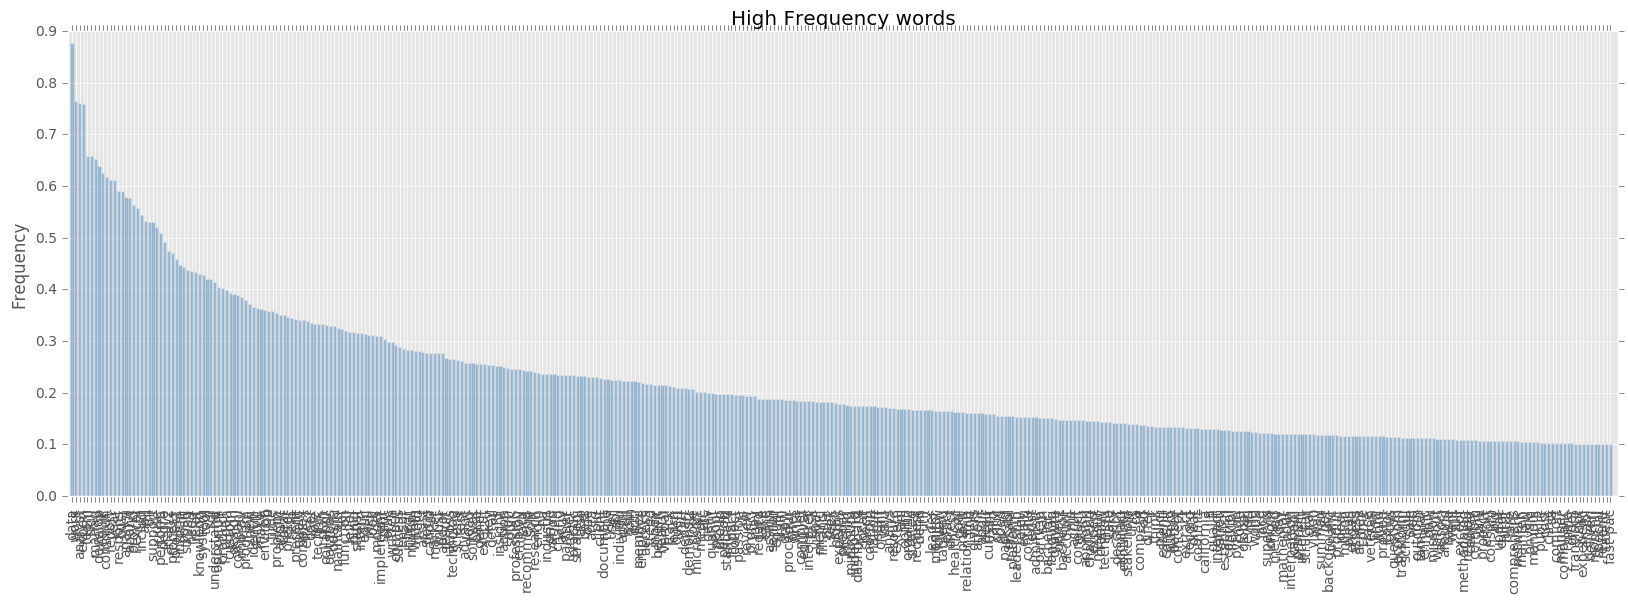

In [8]:
word_barplot(df_sorted_text[df_sorted_text['percent'] > 0.1])

## By using subtitles

### Strategy for Extracting Qualifications
<ol>
    <li> compare all subtitles and find out which subtitles are "Qualifications"
    <li> split text by using subtitles
    <li> compare the word in qualifications and analyze
    
</ol>

### Compare all subtitles and find out which subtitles are "Qualifications"

In [9]:
# get subtitles inside job description
def get_subtitle(post):
    """
    This function takes the post of each job and get all subtitles of the post
    Input: post in html format
    Output: a list of subtitles
    """
    post = BeautifulSoup(post, "lxml")
    try:
        temp = post.find_all('b')        
        subtitles = [sub.text for sub in temp]
    except AttributeError:
        subtitles = []
    return subtitles

# a list containing the subtitles of each post
subtitles = [get_subtitle(post) for post in list(post_summary['description'])]

In [10]:
# Count how many posts don't have subtitles
empty_subtitles = 0
for sub in subtitles:
    if not sub:        
        empty_subtitles += 1
empty_subtitles

261

In [11]:
def diction(files):
    """
    Returns a dictionary from lemmata to document ids containing that lemma
    Input is a data frame
    Output is a dictionary with lemmata as key and document ids as values
    """
    textd = {} 
    for i in range(len(files)):
        # loop over each raw text
        t = ' '.join(files[i])
        # return unique and order list of words appeared in the raw text
        s = set(lemmatize(t))- stop - set(string.punctuation)
        try:
            toks = toks | s   # append to "toks" set a "s"
        except NameError:
            toks = s    # if doesn't exsit, initialize it
        for tok in s:
            try:
                textd[tok].append(i)
            except KeyError:
                textd[tok] = [i]
    
    return textd

In [12]:
# Lemmata of subtitles and the id of posts containing that Lemmata
sub_id = diction(subtitles)

# Lemmata of subtitles and the number of posts containing that Lemmata
sub_num = {key:len(set(val)) for key,val in sub_id.items()}

# Sort sub_num
sorted_sub = [(key, sub_num[key]) for key in sorted(sub_num, key=lambda x : sub_num[x],
                                                              reverse=True)]
df_sorted_sub = pd.DataFrame(sorted_sub)
df_sorted_sub.columns = ['word', '# of posts']
df_sorted_sub.iloc[:50,:]

,word,# of posts
0,respons,163
1,qualif,138
2,requir,117
3,experi,84
4,skill,75
5,job,66
6,educ,65
7,essenti,52
8,duti,49
9,prefer,48


In [13]:
# create a stop word list with high-frequency words in the subtitles
#     so that later we can remove these words from our skills sets
stop_req = list(df_sorted_sub['word'])[:100]

### Split text by using subtitles

In [17]:
keywords = list(df_sorted_sub['word'][1:5])

def get_qual(subtitles):
    """
    This function takes the subtitles and check which subtitle is a subtitle of qualifications
    Input: a list of subtitles
    Output: subtitles of qualifications
    """
    qual = [sub for sub in subtitles if set(lemmatize(sub)).intersection(keywords)]
    return qual

qual_sub = [get_qual(sub) for sub in subtitles]

In [18]:
# Count how many posts don't have qualification subtitles
empty_qual_sub = 0
for qual in qual_sub:
    if not qual:        
        empty_qual_sub += 1
empty_qual_sub

388

### Compare the word in skills and analyze

In [19]:
def qualif_text(text, subtitles):
    '''This function cleans the text file and returns only the part related to skill/qualifications
    Input:  text ------- job description of a job post
            subtitles -- subtitles related to skill/qualifications of the post 
    Output: a str object of the essence of the job description
    '''
    result = text.split(subtitles[0])[1:]
    return result

In [20]:
# Extract text that contains skills
qual_text = []
job_des = list(post_summary['description'])
for i in range(len(qual_sub)):
    job_des[i] = BeautifulSoup(job_des[i], "lxml")
    try:
        job_text = job_des[i].text
    except AttributeError:
        job_text = ''
    try:
        qual_text = qual_text + qualif_text(job_text, qual_sub[i])
    except IndexError:
        qual_text = qual_text + [job_text]


In [21]:
def diction_qual(files):
    """
    Returns a dictionary from lemmata to document ids containing that lemma
    Input is a data frame
    Output is a dictionary with lemmata as key and document ids as values
    """
    textd = {} 
    for i in range(len(files)):
        # loop over each raw text
        t = files[i]
        # return unique and order list of words appeared in the raw text
        s = set(lemmatize(t))- stop - set(string.punctuation) - set(stop_req)
        try:
            toks = toks | s   # append to "toks" set a "s"
        except NameError:
            toks = s    # if doesn't exsit, initialize it
        for tok in s:
            try:
                textd[tok].append(i)
            except KeyError:
                textd[tok] = [i]
    
    return textd


In [22]:
qual_keyw_id = diction_qual(qual_text)
n = len(job_des)
qual_keyw_num = {key:len(set(val)) for key,val in qual_keyw_id.items()}

# Sort sub_num
sorted_qual_keyw = [(key, qual_keyw_num[key]) for key in sorted(qual_keyw_num, key=lambda x : qual_keyw_num[x],
                                                              reverse=True)]
df_sorted_qual = pd.DataFrame(sorted_qual_keyw)
df_sorted_qual.columns = ['word', '# of posts']
df_sorted_qual['percent'] = df_sorted_qual['# of posts']/n
df_sorted_qual.iloc[:50,:]

,word,# of posts,percent
0,degre,307,0.463047
1,develop,306,0.461538
2,use,263,0.396682
3,sql,260,0.392157
4,strong,256,0.386124
5,provid,248,0.374057
6,relat,229,0.345400
7,tool,229,0.345400
8,analyz,226,0.340875
9,support,225,0.339367


/Applications/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


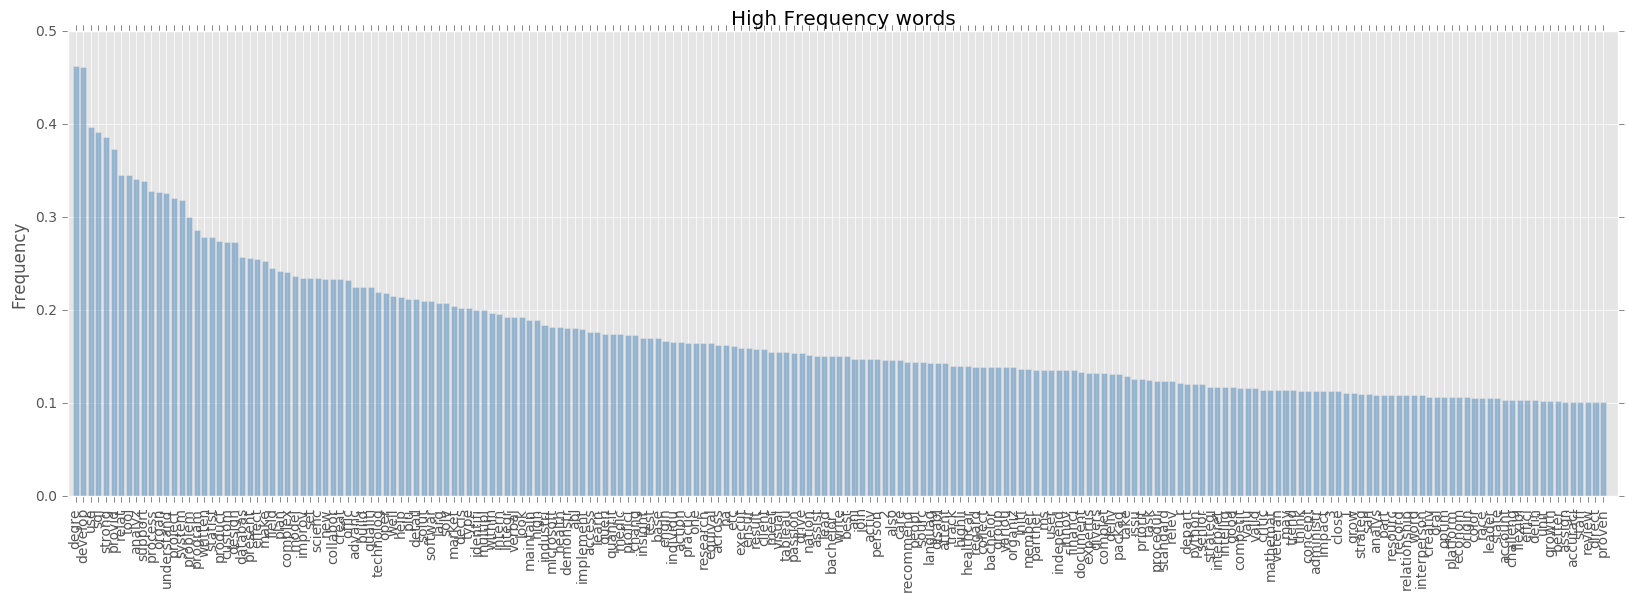

In [24]:
word_barplot(df_sorted_qual[df_sorted_qual['percent']>.1])

# PART 2 Degree Requirement

In [25]:
def degree_require(text):
    '''This function finds whether graduate degree is required in a job description
    Output: scaler of 1 --- requires graduate degree
                      0 --- no requirement for graduate degree
    '''
    kw = ['graduate', 'm.s.', "master's"]
    result = 'undergrad'
    for word in kw:
        if word in text:
            result = 'graduate'
            break
        break
    return result

In [26]:
degree_list = []
for job in job_des:
    #try:
    degree_list = degree_list + [degree_require(job.text)]
    #except AttributeError:
        #degree_list = degree_list + []

In [27]:
# Count how many posts don't have degree requirement
empty_degree = 0
for d in degree_list:
    if not d:        
        empty_degree += 1
empty_degree

0